In [1]:
import os
import numpy as np
import pandas as pd
import codecs

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime

%matplotlib inline

■■■■■　関数　■■■■■

In [2]:
def SaveFig(fig_id, tight_layout=True, fig_extension="png", resolution=600):
   
    images_path = os.path.join("..", "Images", csv_file[:-4])
    os.makedirs(images_path, exist_ok=True)
    path = os.path.join(images_path, fig_id + "." + fig_extension)
    
    #print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    plt.close()

In [3]:
def GetCSVFiles():
    files = os.listdir(R_DATA_PATH)
    csv_files = []
    
    for t in  files:
        if(t[-4:] == '.csv' and t[:2].upper() == "NG"):
             csv_files.append(t)
    
    return csv_files

In [4]:
def PlotDefectivesWithLot(x, y1, y2, fig_id):

    fig = plt.figure(figsize=(14,6))

    #色の設定
    color_1 = "gray"
    color_2 = "blue"

    #プロット
    ax1 = fig.add_subplot(1,1,1)
    ax1.plot(x, y1, ls="None", marker=".", ms=0.7, c=color_1, label="Cumulative Defective Number")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(x, y2, ls="-", c=color_2, drawstyle="steps-post", lw=0.5, label="SA_Lot")
    ax2.yaxis.label.set_color("b")

    #ラベルとハンドラ
    handler1, label1 = ax1.get_legend_handles_labels()
    handler2, label2 = ax2.get_legend_handles_labels()

    # 凡例をまとめて出力する
    ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.5)
 
    #軸の縦線の色を変更．図を重ねているのでax2のみいじる
    ax2.spines["left"].set_color(color_1)
    ax2.spines["right"].set_color(color_2)
 
    #軸の縦線の色を変更している
    ax1.tick_params(axis="y", colors=color_1)
    ax2.tick_params(axis="y", colors=color_2)

    #fig保存
    SaveFig(fig_id)

    #軸の目盛りの単位を変更する
    #ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d個"))
    #ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

In [5]:
def CreateBaseData(csv_file):
    
    #取得列名の定義
    col_process = { "sa_lot": "sa_lot",
                    "out_put_time_" + str(PROCESS_NO): "out_put_time_" + str(PROCESS_NO),
                    "不良カテゴリ_" + str(PROCESS_NO): "DR_Cat_" + str(PROCESS_NO),
                    "Ok情報1(設備)_" + str(PROCESS_NO): "OK1_" + str(PROCESS_NO),
                    "Ok情報2(設備)_" + str(PROCESS_NO): "OK2_" + str(PROCESS_NO),
                    "Ok情報3(設備)_" + str(PROCESS_NO): "OK3_" + str(PROCESS_NO),
                    "工程完了情報1(設備)_" + str(PROCESS_NO): "Proc1_" + str(PROCESS_NO),
                    "工程完了情報2(設備)_" + str(PROCESS_NO): "Proc2_" + str(PROCESS_NO),
                    "工程完了情報3(設備)_" + str(PROCESS_NO): "Proc3_" + str(PROCESS_NO),
                    "キャリアID1(製品種別/ライン)_" + str(PROCESS_NO): "CarrID_Line_" + str(PROCESS_NO),
                    "キャリアID2(工程)_" + str(PROCESS_NO): "CarrID_Proc_" + str(PROCESS_NO),
                    "キャリアID3(シリアルNo1)_" + str(PROCESS_NO): "CarrID_Ser1_" + str(PROCESS_NO),
                    "キャリアID4(シリアルNo2)_" + str(PROCESS_NO): "CarrID_Ser2_" + str(PROCESS_NO)}
    
    #指定工程Noのデータ読み込み
    with codecs.open(os.path.join(R_DATA_PATH, csv_file), "r", "Shift-JIS", "ignore") as f:
        df = pd.read_table(f, delimiter=",", low_memory=False, usecols=col_process.keys())

    #列名をリネーム
    df_process = df.rename(columns=col_process)
    
    #日付：オブジェクト　→　datetimeへ変換
    df_process["out_put_time_" + str(PROCESS_NO)] = pd.to_datetime(df_process["out_put_time_" + str(PROCESS_NO)])
    
    #先にドロップすると，色んな行のNAにヒットしてデータがほぼなくなるので注意
    df_process = df_process.dropna()
    
    return df_process

In [6]:
def PlotWeeklyData(df_process):
   
    df_defcate = (df_process["DR_Cat_" + str(PROCESS_NO)]==31)
    
   #プロット
    x  = df_process["out_put_time_" + str(PROCESS_NO)]
    y1 = df_defcate.cumsum()
    y2 = df_process["sa_lot"]
    fig_id = csv_file[:-4]

    PlotDefectivesWithLot(x, y1, y2, fig_id)

In [23]:
def PlotLotData(df_process):
    
    #1画像データ辺りのロットプロット数
    plt_row = 5
    
    #SAロット毎に分割
    lots = df_process["sa_lot"].unique()
    lots = np.sort(lots)
    
    #イテレータ設定
    i_plt_row = 0
    i_fig_num = 0
    
    #ロット毎にプロット
    for lot in lots:
        i_plt_row += 1
        
        if i_plt_row == 1:
            fig = plt.figure(figsize=(8, 6))
        
        #時系列が戻ったりするので昇順にソート
        df_process_lot = df_process[df_process["sa_lot"]==lot]
        df_process_lot = df_process_lot.sort_values("out_put_time_" + str(PROCESS_NO))
        df_defcate_lot = (df_process_lot["DR_Cat_" + str(PROCESS_NO)]==31)
        
        #プロットデータ
        x = df_process_lot["out_put_time_" + str(PROCESS_NO)]
        y = df_defcate_lot.cumsum()
        
        #グラフ全体設定
        ax = fig.add_subplot(plt_row, 1, i_plt_row)        
        ax.plot(x, y, ls="-", lw=0.5, color="gray", marker="o", ms=1.5, mec="black", mfc="gray", mew=0.5, label="Cumulative Defective Number")
#        ax.legend(loc=2, borderaxespad=0.5)
        ax.set_title(lot, fontsize=10)
        ax.tick_params(labelsize=7)

        #X軸：時系列設定
        xfmt = mdates.DateFormatter("%m/%d_%H:%M")
#        xloc = mdates.HourLocator(byhour=[0,1])
        xloc = mdates.AutoDateLocator()
        ax.xaxis.set_major_locator(xloc)
        ax.xaxis.set_major_formatter(xfmt)
        
        #Y軸：不良数設定
        ax.set_ylim(0, max([20, df_defcate_lot.sum()]))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
        
        ax.grid(True)
  
        if i_plt_row == plt_row:
            i_plt_row = 0
            i_fig_num += 1
            plt.tight_layout()
            SaveFig(str(i_fig_num))
            plt.close()

■■■■■　MainProgram　■■■■■

In [24]:
#定義
R_DATA_PATH = os.path.join("..", "AssemblyData". "Original") #csvデータの保管場所
PROCESS_NO = 16 #工程番号

In [25]:
#データファイル取得
csv_files = GetCSVFiles()

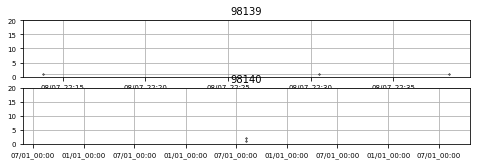

In [26]:
#メインプログラム　グローバル変数だから，これじゃなくてもアクセスできるけど
for csv_file in csv_files:
    df = CreateBaseData(csv_file)
    PlotLotData(df)

■■■■■　確認　■■■■■

■■■■■　失敗作　■■■■■